In [1]:
import pgmpy
import numpy as np
from gmr import GMM
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
import seaborn as sns
from pgmpy.metrics import log_likelihood_score
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import HillClimbSearch, K2Score
import math

%matplotlib inline
import bamt.Networks as Nets
import bamt.Preprocessors as pp


from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import networkx as nx
import random

from sklearn.model_selection import train_test_split


import random
import string

In [2]:
def generate_random_dag(n, p):
    # генерируем случайное дерево
    edges = []
    for i in range(1, n):
        parent = random.randint(0, i - 1)
        edges.append((parent, i))

    # добавляем случайные ребра, пока не получим DAG
    while True:
        new_edge = (random.randint(0, n-1), random.randint(0, n-1))
        #if new_edge[0] >= new_edge[1]:
            #continue  # не добавляем обратное ребро
        if new_edge in edges:
            continue  # не добавляем дубликат ребра
        edges.append(new_edge)
        if is_dag(n, edges): # and len(edges) > int(n*1.5):
            if n > 4:
                if len(edges) >= int(n*(1+random.random())):
                    break
            else:
                break
        else:
            edges.remove(new_edge)
    return edges

def is_dag(n, edges):
    G = nx.DiGraph(edges)
    return nx.is_directed_acyclic_graph(G)

In [12]:
def generate_samples(k_samples=2):
    """
    Случайная смесь Гауссовских распределений
    """
    
    
    # Определение параметров смеси гауссовских распределений
    n_components = random.randint(1, 4) # количество компонентов в смеси

    # Генерация случайных значений для means
    means = np.random.uniform(low=-1, high=1, size=n_components)

    # Генерация случайных значений для covs
    covs = np.random.uniform(low=0.5, high=1, size=n_components)

    # Генерация случайных значений для weights
    weights = np.random.dirichlet(np.ones(n_components), size=1)[0]

    # Создание смеси гауссовских распределений
    from sklearn.mixture import GaussianMixture

    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.means_ = means.reshape(-1, 1)  # преобразование вектора средних значений в столбец
    gmm.covariances_ = np.square(covs).reshape(-1, 1, 1)  # преобразование вектора дисперсий в матрицы ковариации
    gmm.weights_ = weights
    
    X = np.random.random(10**6)
    gmm.fit(X.reshape([-1, 1]))

    # Генерация случайной выборки из смеси гауссовских распределений
    y = gmm.sample(n_samples=10**k_samples) #10^6

    print(f'количество компонентов в смеси: {n_components}')
    print(f'средние значения гауссовских распределений: {means}')
    print(f'Ковариации: {covs}')
    print(f'Веса: {weights}')

#     Визуализация сгенерированной выборки
#     import matplotlib.pyplot as plt

#     plt.hist(X, bins=20)
#     plt.show()
    
    return y[0]

In [4]:
def linear_func(x, k_samples=2):
    
    x = np.array(x)
    a = [random.random()*2-1 for i in x]
    b = [random.random()*2-1 for i in x]
    noise = np.array([np.random.normal(loc=0, scale = 1) for x in range(10**k_samples)]) / 100

    res = sum([a[i]*x[:,i] + b[i] for i in range(x.shape[1])]) + noise
    return res

In [5]:
def init_edges(edges):
    final = [0]*len(edges)
    for ind, edge in enumerate(edges):
        final[ind] = (str(edge[0]) + '_', str(edge[1]) + '_')
    return final

In [6]:
def create_dag(n_nodes, p):
    edges = generate_random_dag(n_nodes, p)
#     print(len(edges))
    G = nx.DiGraph(edges)
    assert nx.is_directed_acyclic_graph(G)
    return G, edges

In [7]:
def create_dataset(edges, k_samples=2):
    connections_to = {}
    connections_from ={}
    edges.sort()
    for ind, edge in enumerate(edges):
        connections_from[ind] = [edges[x][1] for x in range(len(edges)) if edges[x][0]==ind]
        connections_to[ind] = [edges[x][0] for x in range(len(edges)) if edges[x][1]==ind]

    df = pd.DataFrame(generate_samples(k_samples), columns=[str(edges[0][0])])
    remaining_nodes = np.arange(1, n_nodes)
    for i in connections_from[0]:
        if len(connections_to[i]) == 1:
            x = (df[['0']])
            temp_df = pd.DataFrame(linear_func(x, k_samples), columns=[str(i)])
            df = pd.concat([df, temp_df], axis=1)
            remaining_nodes = np.delete(remaining_nodes, np.where(remaining_nodes==i))


    ind = 0
#     print(remaining_nodes)
    while len(remaining_nodes) > 0:
        k = remaining_nodes[ind]
        last_nodes = df.columns
        if len([x for x in connections_to[k] if str(x) in last_nodes]) == len(connections_to[k]):
#             print(str(k))
            x = np.array([0.0]*10**k_samples) #**6
#             print(connections_to[k])
            x = df[list(map(str, connections_to[k]))]
            temp_df = pd.DataFrame(linear_func(x, k_samples), columns=[str(k)])
            df = pd.concat([df, temp_df], axis=1)
            remaining_nodes = np.delete(remaining_nodes, np.where(remaining_nodes==k))
#             print(k)
        else:
            ind += 1
        if ind >= len(remaining_nodes):
            ind = 0
    
    return df

In [8]:
def desc_data(values, columns):
    disc_model = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    disc_model.fit(values)
    sample_disc = pd.DataFrame(disc_model.transform(values), columns=columns)

    return sample_disc

In [9]:
def create_delts(df, edges, k_samples=2):
    delts = []
    start = len(np.unique(edges))
    end = 10**k_samples + start
    step = 100
    for size in range(start, end, step):
        train = df.sample(size)
        G_sample = BayesianNetwork(init_edges(edges))
        G_sample.fit(data=train, estimator=MaximumLikelihoodEstimator)
        score_sample = 0
        try:
            score_sample = log_likelihood_score(G_sample, df)  
#             print(f'size = {size}')
#             print(score_sample)
        except:
            score_sample = -1*np.inf
#         delta = (round(Score_init - score_sample, 3))
        print(size)
        print(delta)
        delts.append(delta)
    
    return delts, G_sample
    

In [10]:
def train_BN(df, size, edges, Score_init):
    train = df.sample(size, random_state=42)
    train_values = train.values
    train_columns = train.columns
    train_sample_disc = desc_data(train_values, train_columns)


    G_sample = BayesianNetwork(init_edges(edges))
    G_sample.fit(
        data=train_sample_disc, 
        estimator=MaximumLikelihoodEstimator
    )

    score_sample = 0
    try:
        score_sample = log_likelihood_score(G_sample, sample_disc)  
    except:
        score_sample = -1*np.inf
    delta = (round(Score_init - score_sample, 3))
    
    return delta

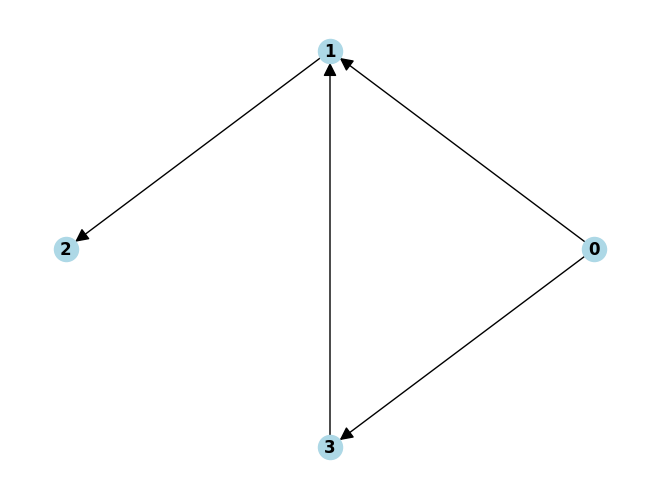

количество компонентов в смеси: 2
средние значения гауссовских распределений: [-0.07831748 -0.06456693]
Ковариации: [0.93832106 0.7589026 ]
Веса: [0.02144017 0.97855983]
4 5 inf
4 1005 inf
4 2005 inf
4 3005 inf
4 4005 inf
4 5005 inf
4 6005 inf
4 7005 inf
4 8005 inf
4 9005 inf
4 10005 inf
4 11005 inf
4 12005 inf
4 13005 inf
4 14005 inf
4 15005 inf
4 16005 inf
4 17005 inf
4 18005 inf
4 19005 inf
4 20005 inf
4 21005 inf
4 22005 inf
4 23005 inf
4 24005 inf
4 25005 inf
4 26005 inf
4 27005 inf
4 28005 inf
4 29005 inf
4 30005 inf
4 31005 inf
4 32005 inf
4 33005 inf
4 34005 inf
4 35005 inf
4 36005 inf
4 37005 inf
4 38005 inf
4 39005 inf
4 40005 inf
4 41005 inf
4 42005 inf
4 43005 inf
4 44005 inf
4 45005 inf
4 46005 inf
4 47005 inf
4 48005 inf
4 49005 inf
4 50005 inf
4 51005 inf
4 52005 inf
4 53005 inf
4 54005 inf
4 55005 inf
4 56005 inf
4 57005 inf
4 58005 inf
4 59005 inf
4 60005 inf
4 61005 inf
4 62005 inf
4 63005 inf
4 64005 inf
4 65005 inf
4 66005 inf
4 67005 inf
4 68005 inf
4 69005 inf
4 7

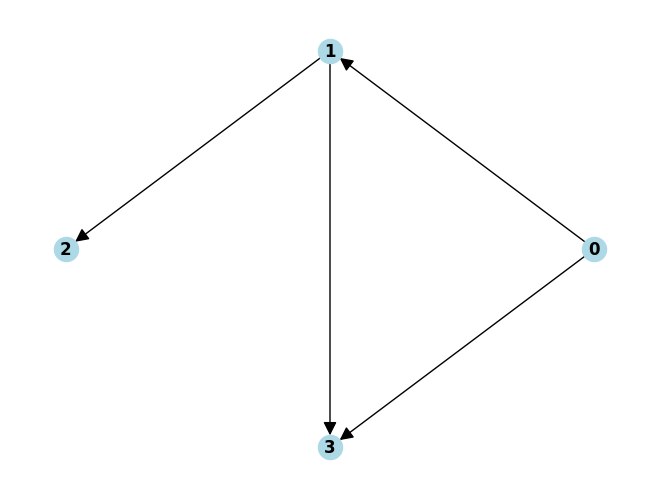

количество компонентов в смеси: 3
средние значения гауссовских распределений: [ 0.0592754  -0.36972173 -0.33484431]
Ковариации: [0.74311849 0.96444202 0.9228657 ]
Веса: [0.44438189 0.13737247 0.41824564]
4 5 inf
4 1005 1065.098
4 2005 556.25
4 3005 210.015
4 4005 189.798
4 5005 208.331
4 6005 190.991
4 7005 87.552
4 8005 108.007
4 9005 119.496
4 10005 129.878
4 11005 124.749
4 12005 93.832
4 13005 75.778
4 14005 74.579
4 15005 54.015
4 16005 68.464
4 17005 72.116
4 18005 65.406
4 19005 56.182
4 20005 39.349
4 21005 36.352
4 22005 26.094
4 23005 29.93
4 24005 28.537
4 25005 24.337
4 26005 25.394
4 27005 19.763
4 28005 21.06
4 29005 19.565
4 30005 17.335
4 31005 19.83
4 32005 23.746
4 33005 22.219
4 34005 22.058
4 35005 20.626
4 36005 15.661
4 37005 18.27
4 38005 14.083
4 39005 10.5
4 40005 7.852
4 41005 12.402
4 42005 13.621
4 43005 11.896
4 44005 12.299
4 45005 14.266
4 46005 14.914
4 47005 18.95
4 48005 17.234
4 49005 20.911
4 50005 15.114
4 51005 17.935
4 52005 18.941
4 53005 19.032


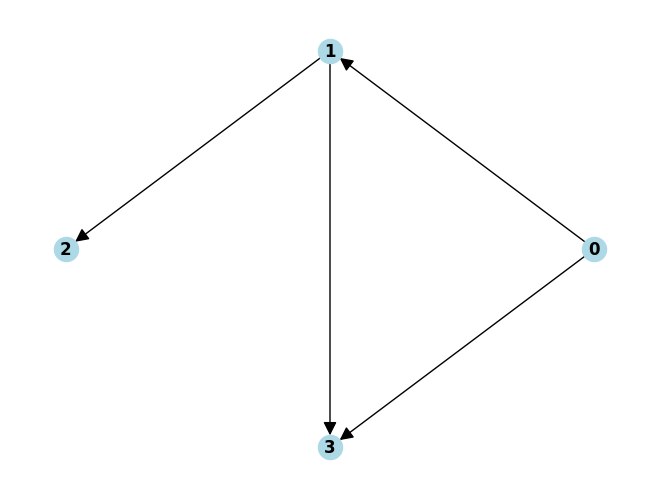

количество компонентов в смеси: 4
средние значения гауссовских распределений: [ 0.40280251 -0.77087698  0.45804667 -0.81299285]
Ковариации: [0.895133   0.748989   0.80066034 0.99506092]
Веса: [0.0064619  0.20692108 0.53444169 0.25217533]
4 5 inf
4 1005 inf
4 2005 inf
4 3005 inf
4 4005 inf
4 5005 inf
4 6005 inf
4 7005 inf
4 8005 inf
4 9005 inf
4 10005 inf
4 11005 inf
4 12005 inf
4 13005 inf
4 14005 inf
4 15005 inf
4 16005 inf
4 17005 inf
4 18005 inf
4 19005 inf
4 20005 inf
4 21005 inf
4 22005 inf
4 23005 inf
4 24005 inf
4 25005 inf
4 26005 inf
4 27005 inf
4 28005 inf
4 29005 inf
4 30005 inf
4 31005 inf
4 32005 inf
4 33005 inf
4 34005 inf
4 35005 inf
4 36005 inf
4 37005 inf
4 38005 inf
4 39005 inf
4 40005 inf
4 41005 inf
4 42005 inf
4 43005 inf
4 44005 inf
4 45005 inf
4 46005 inf
4 47005 inf
4 48005 inf
4 49005 inf
4 50005 inf
4 51005 inf
4 52005 inf
4 53005 inf
4 54005 inf
4 55005 inf
4 56005 16.395
4 57005 17.43
4 58005 12.93
4 59005 12.512
4 60005 12.13
4 61005 14.545
4 62005 11.507
4

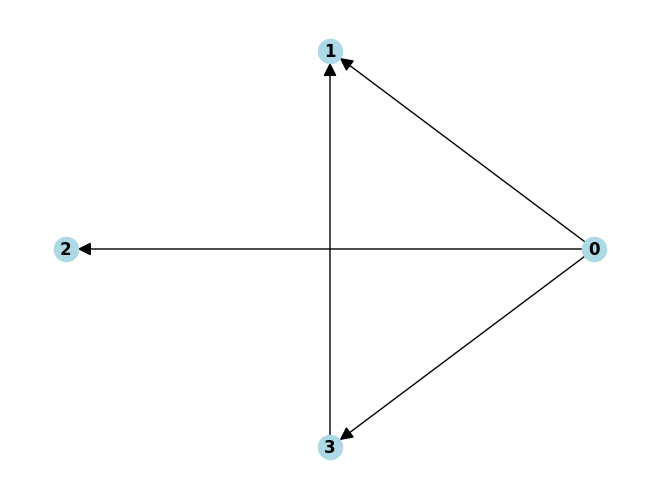

количество компонентов в смеси: 2
средние значения гауссовских распределений: [-0.29733351  0.04357321]
Ковариации: [0.85972096 0.87684131]
Веса: [0.12589045 0.87410955]
4 5 inf
4 1005 inf
4 2005 613.353
4 3005 402.037
4 4005 368.359
4 5005 248.97
4 6005 358.199
4 7005 364.075
4 8005 273.992
4 9005 229.447
4 10005 221.494
4 11005 191.791
4 12005 165.585
4 13005 147.349
4 14005 124.992
4 15005 95.392
4 16005 83.817
4 17005 82.877
4 18005 75.466
4 19005 68.397
4 20005 50.819
4 21005 54.661
4 22005 60.531
4 23005 53.851
4 24005 59.391
4 25005 65.334
4 26005 64.171
4 27005 66.555
4 28005 61.012
4 29005 54.138
4 30005 55.159
4 31005 42.726
4 32005 54.013
4 33005 39.25
4 34005 34.555
4 35005 32.015
4 36005 32.064
4 37005 32.384
4 38005 28.488
4 39005 26.225
4 40005 24.059
4 41005 29.098
4 42005 24.382
4 43005 28.258
4 44005 24.142
4 45005 21.976
4 46005 23.676
4 47005 26.509
4 48005 27.291
4 49005 29.694
4 50005 26.617
4 51005 25.51
4 52005 23.609
4 53005 22.605
4 54005 25.886
4 55005 21.524

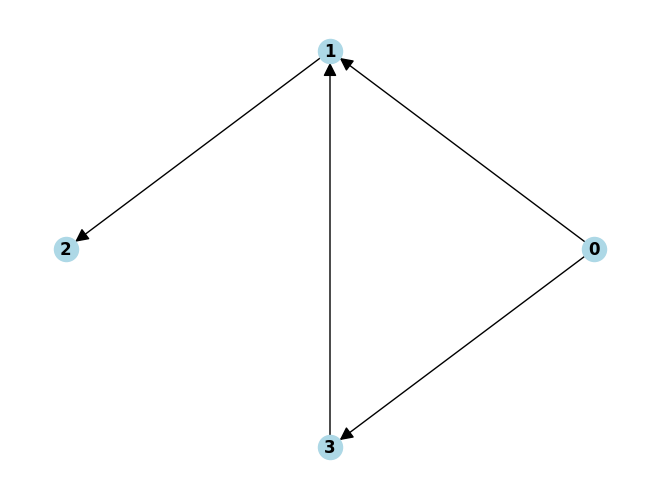

количество компонентов в смеси: 2
средние значения гауссовских распределений: [-0.23717474 -0.87190865]
Ковариации: [0.79291073 0.80354441]
Веса: [0.07912191 0.92087809]
4 5 inf
4 1005 inf
4 2005 inf
4 3005 inf
4 4005 inf
4 5005 inf
4 6005 inf
4 7005 inf
4 8005 inf
4 9005 inf
4 10005 inf
4 11005 inf
4 12005 inf
4 13005 inf
4 14005 inf
4 15005 inf
4 16005 inf
4 17005 inf
4 18005 inf
4 19005 inf
4 20005 inf
4 21005 inf
4 22005 inf
4 23005 inf
4 24005 inf
4 25005 inf
4 26005 inf
4 27005 inf
4 28005 inf
4 29005 inf
4 30005 inf
4 31005 inf
4 32005 inf
4 33005 inf
4 34005 inf
4 35005 inf
4 36005 inf
4 37005 inf
4 38005 inf
4 39005 19.13
4 40005 16.946
4 41005 18.274
4 42005 19.704
4 43005 18.883
4 44005 21.036
4 45005 19.273
4 46005 18.197
4 47005 16.524
4 48005 16.305
4 49005 15.184
4 50005 14.409
4 51005 15.612
4 52005 15.571
4 53005 15.325
4 54005 15.82
4 55005 15.717
4 56005 15.849
4 57005 13.505
4 58005 10.985
4 59005 12.702
4 60005 12.53
4 61005 11.9
4 62005 11.128
4 63005 9.423
4 6400

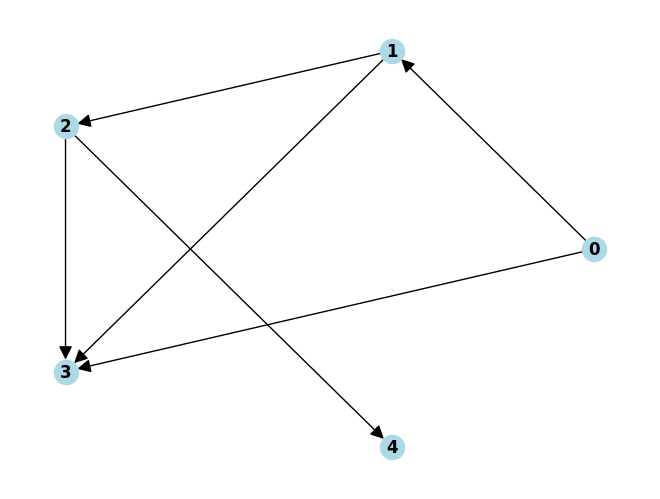

количество компонентов в смеси: 2
средние значения гауссовских распределений: [0.93376851 0.17103988]
Ковариации: [0.64126087 0.79888172]
Веса: [0.3293261 0.6706739]
5 6 inf
5 1006 inf
5 2006 inf
5 3006 inf
5 4006 inf
5 5006 inf
5 6006 inf
5 7006 inf
5 8006 inf
5 9006 inf
5 10006 inf
5 11006 inf
5 12006 inf
5 13006 inf
5 14006 inf
5 15006 inf
5 16006 inf
5 17006 inf
5 18006 inf
5 19006 inf
5 20006 inf
5 21006 inf
5 22006 inf
5 23006 inf
5 24006 inf
5 25006 inf
5 26006 inf
5 27006 inf
5 28006 inf
5 29006 inf
5 30006 inf
5 31006 inf
5 32006 inf
5 33006 inf
5 34006 inf
5 35006 inf
5 36006 inf
5 37006 inf
5 38006 inf
5 39006 inf
5 40006 inf
5 41006 inf
5 42006 inf
5 43006 inf
5 44006 inf
5 45006 inf
5 46006 inf
5 47006 inf
5 48006 inf
5 49006 inf
5 50006 inf
5 51006 inf
5 52006 inf
5 53006 inf
5 54006 inf
5 55006 inf
5 56006 inf
5 57006 inf
5 58006 14.815
5 59006 18.179
5 60006 13.659
5 61006 16.028
5 62006 15.005
5 63006 16.227
5 64006 15.585
5 65006 15.92
5 66006 13.101
5 67006 13.944
5 

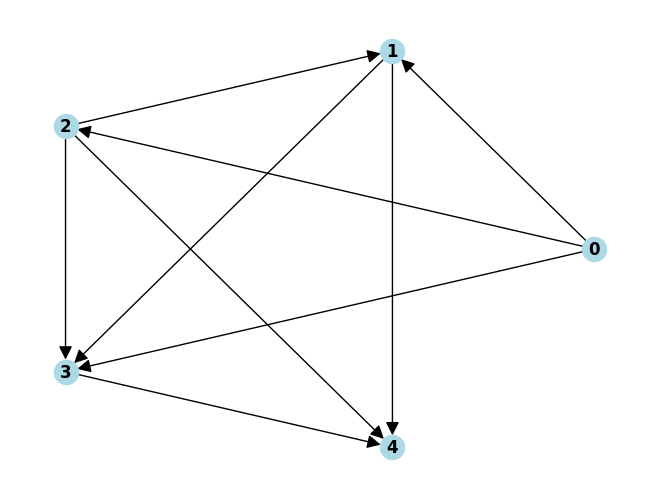

количество компонентов в смеси: 4
средние значения гауссовских распределений: [-0.28460283 -0.2025355   0.87613469  0.47261146]
Ковариации: [0.77683065 0.8703691  0.60107693 0.50931826]
Веса: [0.41806138 0.01726546 0.42943662 0.13523654]
5 6 inf
5 1006 inf
5 2006 inf
5 3006 inf
5 4006 inf
5 5006 inf
5 6006 inf
5 7006 inf
5 8006 inf
5 9006 inf
5 10006 inf
5 11006 inf
5 12006 inf
5 13006 inf
5 14006 inf
5 15006 inf
5 16006 inf
5 17006 inf
5 18006 inf
5 19006 inf
5 20006 inf
5 21006 inf
5 22006 inf
5 23006 inf
5 24006 inf
5 25006 inf
5 26006 inf
5 27006 inf
5 28006 inf
5 29006 inf
5 30006 inf
5 31006 inf
5 32006 inf
5 33006 inf
5 34006 inf
5 35006 inf
5 36006 inf
5 37006 inf
5 38006 inf
5 39006 inf
5 40006 inf
5 41006 inf
5 42006 inf
5 43006 inf
5 44006 inf
5 45006 inf
5 46006 inf
5 47006 inf
5 48006 inf
5 49006 inf
5 50006 inf
5 51006 inf
5 52006 inf
5 53006 inf
5 54006 inf
5 55006 inf
5 56006 inf
5 57006 inf
5 58006 inf
5 59006 inf
5 60006 inf
5 61006 inf
5 62006 inf
5 63006 inf
5 64006

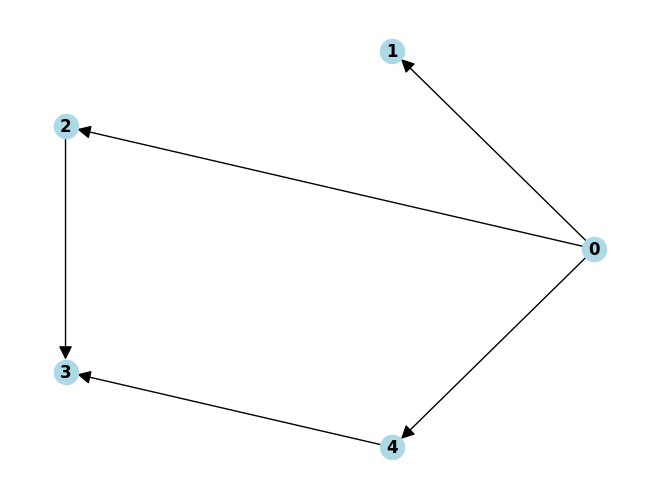

количество компонентов в смеси: 4
средние значения гауссовских распределений: [ 0.48090125 -0.63422771  0.42219752  0.27484385]
Ковариации: [0.51858292 0.70135472 0.77965666 0.87727217]
Веса: [0.19024747 0.12952028 0.23479357 0.44543868]
5 6 inf
5 1006 inf
5 2006 2101.329
5 3006 1365.464
5 4006 874.482
5 5006 754.048
5 6006 453.88
5 7006 377.147
5 8006 306.937
5 9006 287.842
5 10006 292.89
5 11006 283.144
5 12006 254.07
5 13006 265.574
5 14006 220.539
5 15006 197.46
5 16006 165.192
5 17006 134.567
5 18006 121.943
5 19006 122.498
5 20006 120.062
5 21006 117.986
5 22006 102.625
5 23006 108.087
5 24006 104.643
5 25006 102.097
5 26006 104.46
5 27006 90.544
5 28006 95.591
5 29006 80.476
5 30006 76.627
5 31006 72.861
5 32006 77.028
5 33006 78.527
5 34006 74.906
5 35006 71.039
5 36006 66.771
5 37006 69.332
5 38006 69.899
5 39006 68.309
5 40006 62.719
5 41006 62.347
5 42006 65.606
5 43006 61.641
5 44006 63.148
5 45006 59.822
5 46006 56.291
5 47006 53.208
5 48006 50.274
5 49006 47.108
5 50006 4

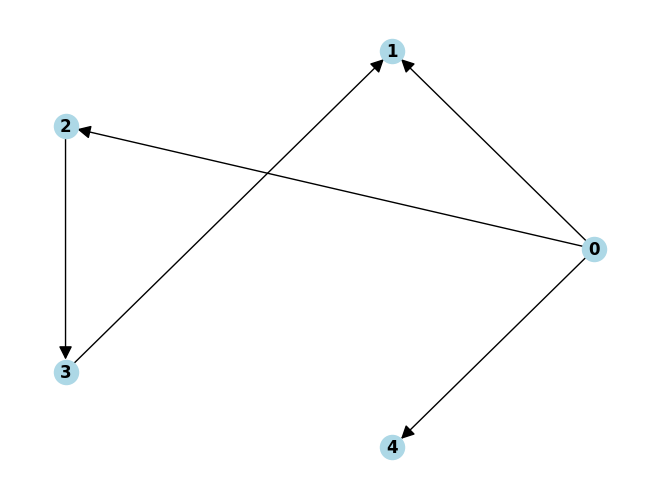

количество компонентов в смеси: 3
средние значения гауссовских распределений: [ 0.48678235 -0.69654605  0.38066835]
Ковариации: [0.66950443 0.61344597 0.90521462]
Веса: [0.43509701 0.33113416 0.23376883]
5 6 inf
5 1006 inf
5 2006 inf
5 3006 inf
5 4006 inf
5 5006 inf
5 6006 inf
5 7006 inf
5 8006 inf
5 9006 inf
5 10006 282.267
5 11006 inf
5 12006 inf
5 13006 inf
5 14006 inf
5 15006 inf
5 16006 inf
5 17006 inf
5 18006 130.1
5 19006 121.275
5 20006 115.954
5 21006 132.595
5 22006 121.463
5 23006 118.965
5 24006 117.923
5 25006 115.411
5 26006 120.745
5 27006 125.763
5 28006 116.041
5 29006 97.879
5 30006 94.495
5 31006 100.937
5 32006 94.255
5 33006 89.627
5 34006 81.854
5 35006 73.42
5 36006 64.541
5 37006 68.262
5 38006 58.656
5 39006 47.272
5 40006 51.968
5 41006 58.365
5 42006 60.903
5 43006 59.175
5 44006 53.764
5 45006 50.472
5 46006 50.171
5 47006 44.41
5 48006 45.046
5 49006 42.322
5 50006 39.362
5 51006 35.997
5 52006 38.939
5 53006 39.993
5 54006 43.371
5 55006 38.728
5 56006 35.

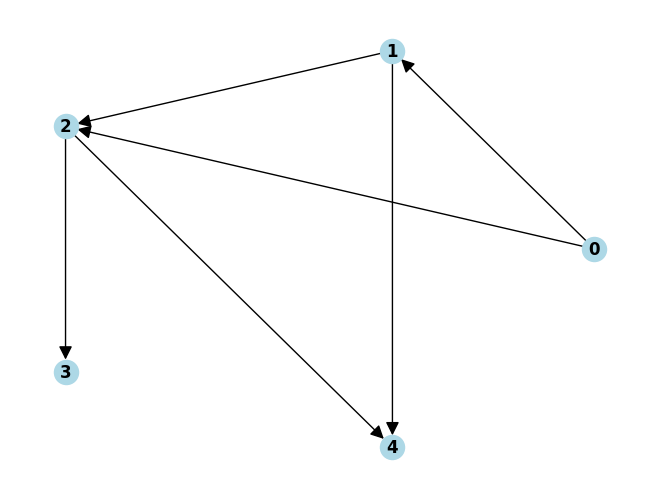

количество компонентов в смеси: 4
средние значения гауссовских распределений: [-0.42635886 -0.06424761  0.74473099 -0.5288229 ]
Ковариации: [0.53964976 0.60179761 0.61200141 0.82875495]
Веса: [0.00987358 0.42747654 0.35255766 0.21009222]
5 6 inf
5 1006 inf
5 2006 inf
5 3006 inf
5 4006 inf
5 5006 inf
5 6006 inf
5 7006 inf
5 8006 inf
5 9006 inf
5 10006 inf
5 11006 inf
5 12006 inf
5 13006 inf
5 14006 inf
5 15006 inf
5 16006 inf
5 17006 inf
5 18006 inf
5 19006 inf
5 20006 inf
5 21006 inf
5 22006 inf
5 23006 inf
5 24006 inf
5 25006 inf
5 26006 inf
5 27006 inf
5 28006 inf
5 29006 inf
5 30006 inf
5 31006 inf
5 32006 inf
5 33006 inf
5 34006 inf
5 35006 inf
5 36006 inf
5 37006 inf
5 38006 104.636
5 39006 92.007
5 40006 97.455
5 41006 89.748
5 42006 87.561
5 43006 80.053
5 44006 73.161
5 45006 66.328
5 46006 68.404
5 47006 64.926
5 48006 64.557
5 49006 60.942
5 50006 60.073
5 51006 55.96
5 52006 56.054
5 53006 52.708
5 54006 52.226
5 55006 51.115
5 56006 48.428
5 57006 45.346
5 58006 42.887
5 59

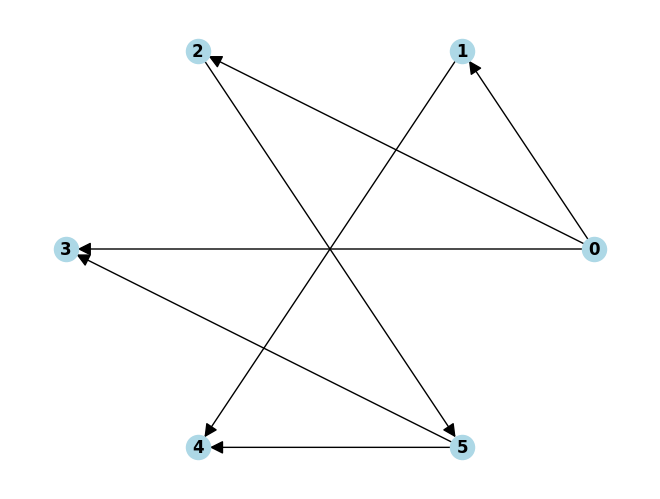

количество компонентов в смеси: 3
средние значения гауссовских распределений: [ 0.59511008  0.2452254  -0.81788138]
Ковариации: [0.70475052 0.93749351 0.6004587 ]
Веса: [0.0979581  0.14425805 0.75778385]
6 7 inf
6 1007 inf
6 2007 inf
6 3007 inf
6 4007 inf
6 5007 inf
6 6007 inf
6 7007 inf
6 8007 inf
6 9007 inf
6 10007 inf
6 11007 inf
6 12007 inf
6 13007 inf
6 14007 inf
6 15007 inf
6 16007 inf
6 17007 inf
6 18007 inf
6 19007 inf
6 20007 inf
6 21007 inf
6 22007 inf
6 23007 inf
6 24007 inf
6 25007 inf
6 26007 inf
6 27007 inf
6 28007 inf
6 29007 inf
6 30007 inf
6 31007 inf
6 32007 inf
6 33007 inf
6 34007 inf
6 35007 inf
6 36007 inf
6 37007 inf
6 38007 inf
6 39007 inf
6 40007 inf
6 41007 inf
6 42007 inf
6 43007 inf
6 44007 inf
6 45007 inf
6 46007 inf
6 47007 inf
6 48007 inf
6 49007 inf
6 50007 inf
6 51007 inf
6 52007 inf
6 53007 inf
6 54007 inf
6 55007 inf
6 56007 inf
6 57007 inf
6 58007 inf
6 59007 inf
6 60007 inf
6 61007 inf
6 62007 inf
6 63007 inf
6 64007 inf
6 65007 inf
6 66007 inf
6 670

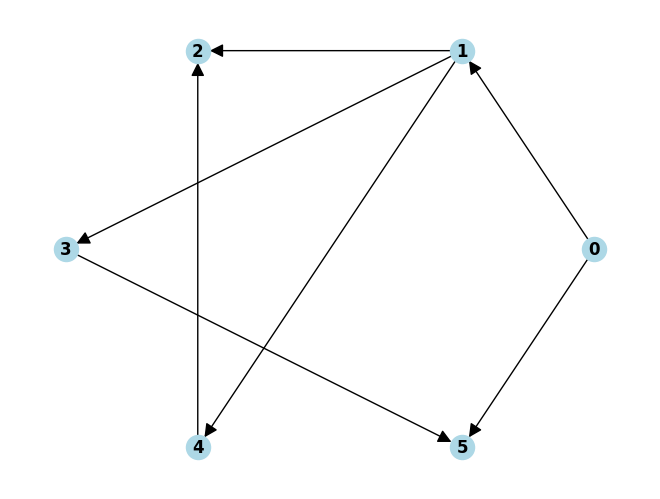

количество компонентов в смеси: 2
средние значения гауссовских распределений: [-0.73345304  0.11829871]
Ковариации: [0.56466989 0.74026585]
Веса: [0.25319 0.74681]
6 7 inf
6 1007 inf
6 2007 inf
6 3007 inf
6 4007 inf
6 5007 inf
6 6007 inf
6 7007 inf
6 8007 inf
6 9007 inf
6 10007 inf
6 11007 inf
6 12007 inf
6 13007 inf
6 14007 inf
6 15007 inf
6 16007 inf
6 17007 inf
6 18007 inf
6 19007 inf
6 20007 inf
6 21007 inf
6 22007 inf
6 23007 inf
6 24007 inf
6 25007 inf
6 26007 inf
6 27007 inf
6 28007 inf
6 29007 inf
6 30007 inf
6 31007 inf
6 32007 inf
6 33007 inf
6 34007 inf
6 35007 inf
6 36007 inf
6 37007 inf
6 38007 inf
6 39007 inf
6 40007 inf
6 41007 inf
6 42007 inf
6 43007 inf
6 44007 inf
6 45007 inf
6 46007 inf
6 47007 inf
6 48007 inf
6 49007 inf
6 50007 inf
6 51007 inf
6 52007 inf
6 53007 inf
6 54007 inf
6 55007 inf
6 56007 inf
6 57007 inf
6 58007 inf
6 59007 inf
6 60007 inf
6 61007 inf
6 62007 inf
6 63007 inf
6 64007 inf
6 65007 inf
6 66007 inf
6 67007 inf
6 68007 inf
6 69007 inf
6 70007 i

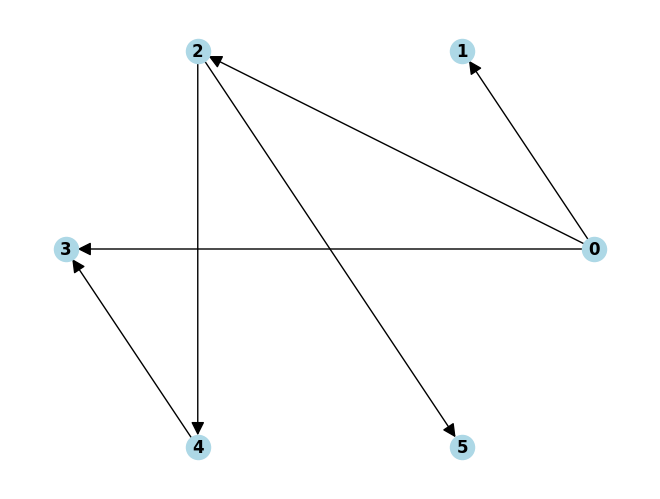

количество компонентов в смеси: 4
средние значения гауссовских распределений: [-0.66707111 -0.84266985 -0.40532651 -0.64448675]
Ковариации: [0.78817381 0.56575434 0.68230391 0.59463028]
Веса: [0.33589027 0.4195917  0.04613049 0.19838753]
6 7 inf
6 1007 inf
6 2007 inf
6 3007 inf
6 4007 inf
6 5007 inf
6 6007 inf
6 7007 inf
6 8007 inf
6 9007 inf
6 10007 inf
6 11007 inf
6 12007 inf
6 13007 inf
6 14007 inf
6 15007 inf
6 16007 inf
6 17007 inf
6 18007 inf
6 19007 inf
6 20007 inf
6 21007 inf
6 22007 inf
6 23007 inf
6 24007 inf
6 25007 inf
6 26007 inf
6 27007 inf
6 28007 inf
6 29007 inf
6 30007 inf
6 31007 inf
6 32007 inf
6 33007 inf
6 34007 inf
6 35007 inf
6 36007 inf
6 37007 inf
6 38007 inf
6 39007 inf
6 40007 inf
6 41007 inf
6 42007 inf
6 43007 inf
6 44007 inf
6 45007 inf
6 46007 inf
6 47007 inf
6 48007 inf
6 49007 inf
6 50007 inf
6 51007 inf
6 52007 inf
6 53007 inf
6 54007 inf
6 55007 inf
6 56007 inf
6 57007 inf
6 58007 inf
6 59007 52.644
6 60007 50.279
6 61007 48.491
6 62007 43.233
6 63007

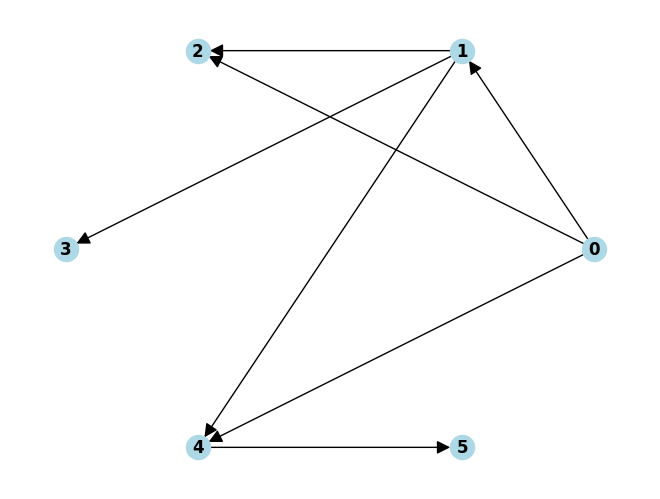

количество компонентов в смеси: 3
средние значения гауссовских распределений: [-0.6566702   0.23622696  0.71792752]
Ковариации: [0.56125024 0.83652234 0.59565621]
Веса: [0.00276765 0.55868856 0.4385438 ]
6 7 inf
6 1007 inf
6 2007 inf
6 3007 inf
6 4007 inf
6 5007 inf
6 6007 inf
6 7007 inf
6 8007 inf
6 9007 inf
6 10007 inf
6 11007 inf
6 12007 inf
6 13007 inf
6 14007 inf
6 15007 inf
6 16007 inf
6 17007 inf
6 18007 inf
6 19007 inf
6 20007 inf
6 21007 inf
6 22007 inf
6 23007 inf
6 24007 inf
6 25007 inf
6 26007 inf
6 27007 inf
6 28007 inf
6 29007 inf
6 30007 inf
6 31007 inf
6 32007 inf
6 33007 inf
6 34007 inf
6 35007 inf
6 36007 inf
6 37007 inf
6 38007 inf
6 39007 inf
6 40007 inf
6 41007 inf
6 42007 inf
6 43007 inf
6 44007 inf
6 45007 inf
6 46007 inf
6 47007 inf
6 48007 inf
6 49007 inf
6 50007 inf
6 51007 inf
6 52007 inf
6 53007 inf
6 54007 inf
6 55007 inf
6 56007 inf
6 57007 inf
6 58007 inf
6 59007 inf
6 60007 inf
6 61007 inf
6 62007 inf
6 63007 inf
6 64007 inf
6 65007 inf
6 66007 inf
6 670

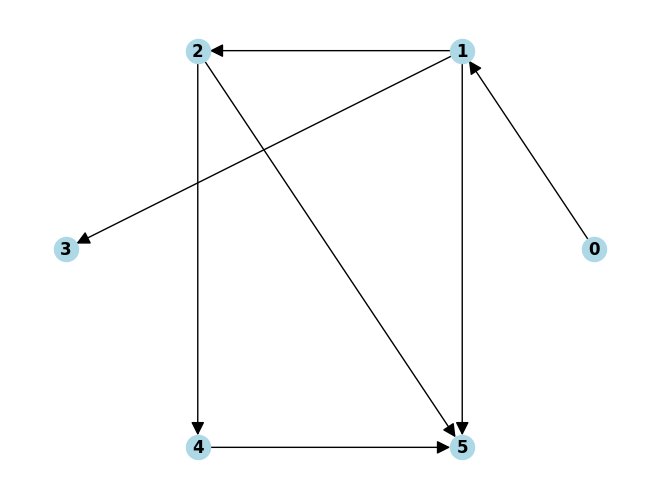

количество компонентов в смеси: 4
средние значения гауссовских распределений: [-0.81372953  0.66474023 -0.6533499  -0.19971894]
Ковариации: [0.78573327 0.80811642 0.52743569 0.91291523]
Веса: [0.54859059 0.25143629 0.00704032 0.19293281]
6 7 inf
6 1007 inf
6 2007 inf
6 3007 inf
6 4007 inf
6 5007 inf
6 6007 inf
6 7007 inf
6 8007 inf
6 9007 inf
6 10007 inf
6 11007 inf
6 12007 inf
6 13007 inf
6 14007 inf
6 15007 inf
6 16007 inf
6 17007 inf
6 18007 inf
6 19007 inf
6 20007 inf
6 21007 inf
6 22007 inf
6 23007 inf
6 24007 inf
6 25007 inf
6 26007 inf
6 27007 inf
6 28007 inf
6 29007 inf
6 30007 inf
6 31007 inf
6 32007 inf
6 33007 inf
6 34007 inf
6 35007 inf
6 36007 inf
6 37007 inf
6 38007 inf
6 39007 inf
6 40007 inf
6 41007 inf
6 42007 inf
6 43007 inf
6 44007 inf
6 45007 inf
6 46007 inf
6 47007 inf
6 48007 inf
6 49007 inf
6 50007 inf
6 51007 inf
6 52007 inf
6 53007 inf
6 54007 inf
6 55007 inf
6 56007 inf
6 57007 inf
6 58007 inf
6 59007 inf
6 60007 inf
6 61007 inf
6 62007 inf
6 63007 inf
6 64007

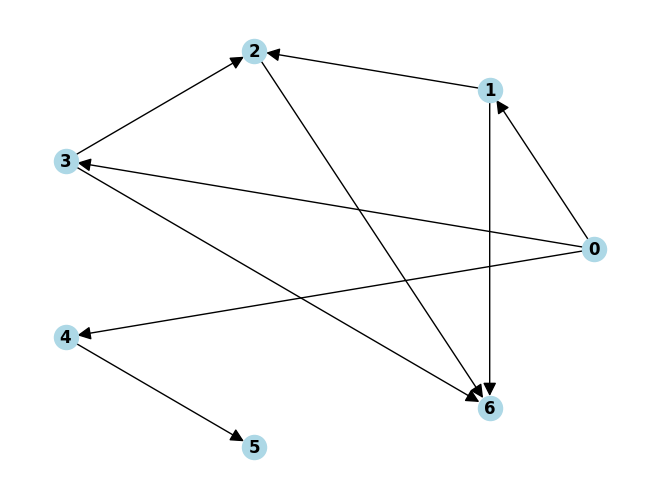

количество компонентов в смеси: 3
средние значения гауссовских распределений: [-0.07981329 -0.23280186  0.1532224 ]
Ковариации: [0.50091423 0.77775623 0.71148989]
Веса: [0.17863764 0.24542652 0.57593585]
7 8 inf
7 1008 inf
7 2008 inf
7 3008 inf
7 4008 inf
7 5008 inf
7 6008 inf
7 7008 inf
7 8008 inf
7 9008 inf
7 10008 inf
7 11008 inf
7 12008 inf
7 13008 inf
7 14008 inf
7 15008 inf
7 16008 inf
7 17008 inf
7 18008 inf
7 19008 inf
7 20008 inf
7 21008 inf
7 22008 inf
7 23008 inf
7 24008 inf
7 25008 inf
7 26008 inf
7 27008 inf
7 28008 inf
7 29008 inf
7 30008 inf
7 31008 inf
7 32008 inf
7 33008 inf
7 34008 inf
7 35008 inf
7 36008 inf
7 37008 inf
7 38008 inf
7 39008 inf
7 40008 inf
7 41008 inf
7 42008 inf
7 43008 inf
7 44008 inf
7 45008 inf
7 46008 inf
7 47008 inf
7 48008 inf
7 49008 inf
7 50008 inf
7 51008 inf
7 52008 inf
7 53008 inf
7 54008 inf
7 55008 inf
7 56008 inf
7 57008 inf
7 58008 inf
7 59008 inf
7 60008 inf
7 61008 inf
7 62008 inf
7 63008 inf
7 64008 inf
7 65008 inf
7 66008 inf
7 670

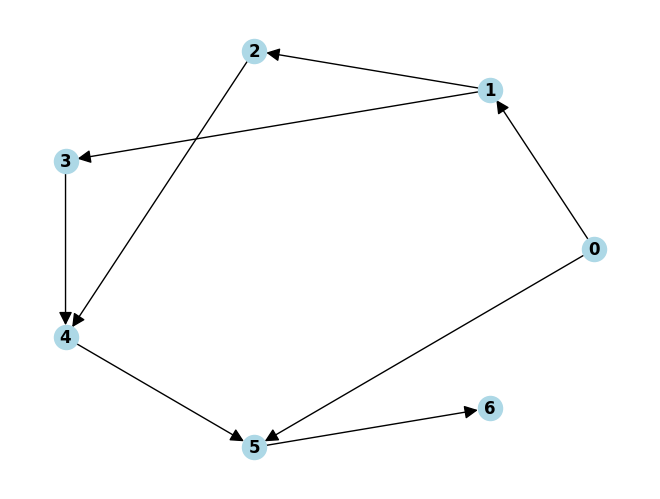

количество компонентов в смеси: 4
средние значения гауссовских распределений: [ 0.48568351 -0.39234371 -0.34510146 -0.89157276]
Ковариации: [0.63595144 0.72983657 0.94555171 0.73011326]
Веса: [0.26256597 0.23995758 0.47488679 0.02258966]
7 8 inf
7 1008 inf
7 2008 inf
7 3008 inf
7 4008 inf
7 5008 inf
7 6008 inf
7 7008 inf
7 8008 inf
7 9008 inf
7 10008 inf
7 11008 inf
7 12008 inf
7 13008 inf
7 14008 inf
7 15008 inf
7 16008 206.027
7 17008 201.178
7 18008 178.555
7 19008 174.832
7 20008 166.23
7 21008 153.8
7 22008 149.685
7 23008 136.424
7 24008 141.992
7 25008 128.032
7 26008 122.639
7 27008 124.887
7 28008 128.161
7 29008 107.001
7 30008 107.775
7 31008 103.985
7 32008 96.944
7 33008 106.914
7 34008 102.381
7 35008 99.907
7 36008 92.164
7 37008 96.583
7 38008 89.928
7 39008 88.71
7 40008 85.039
7 41008 89.297
7 42008 80.207
7 43008 75.932
7 44008 72.348
7 45008 72.563
7 46008 67.215
7 47008 66.658
7 48008 70.495
7 49008 69.548
7 50008 69.513
7 51008 69.29
7 52008 65.834
7 53008 64.327


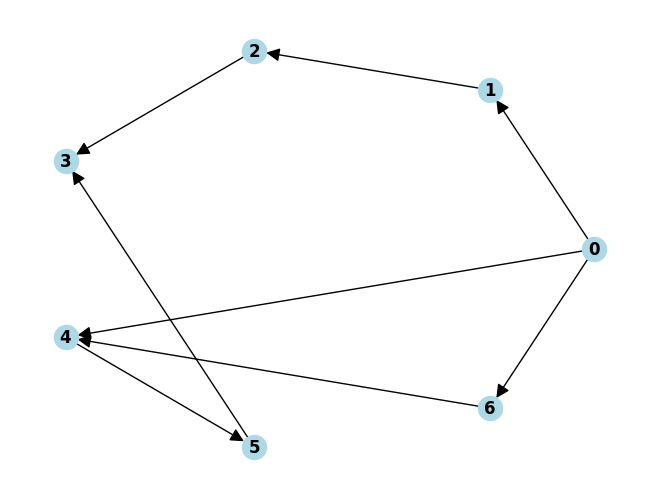

количество компонентов в смеси: 4
средние значения гауссовских распределений: [ 0.86071692 -0.38669656 -0.9403792  -0.3589959 ]
Ковариации: [0.5228989  0.93474601 0.98814437 0.51467831]
Веса: [0.28405596 0.08095939 0.53728801 0.09769664]
7 8 inf
7 1008 1337.373
7 2008 966.131
7 3008 587.859
7 4008 543.036
7 5008 420.019
7 6008 350.776
7 7008 211.638
7 8008 227.19
7 9008 179.205
7 10008 169.594
7 11008 194.879
7 12008 159.219
7 13008 146.694
7 14008 133.246
7 15008 112.268
7 16008 138.623
7 17008 122.807
7 18008 118.732
7 19008 108.331
7 20008 73.218
7 21008 61.553
7 22008 56.461
7 23008 51.855
7 24008 53.012
7 25008 45.992
7 26008 47.778
7 27008 50.989
7 28008 48.784
7 29008 43.529
7 30008 40.924
7 31008 44.35
7 32008 41.772
7 33008 43.863
7 34008 40.867
7 35008 40.73
7 36008 41.95
7 37008 42.564
7 38008 35.411
7 39008 43.078
7 40008 37.151
7 41008 36.248
7 42008 38.901
7 43008 42.96
7 44008 32.067
7 45008 33.879
7 46008 27.545
7 47008 28.548
7 48008 29.56
7 49008 25.299
7 50008 23.329

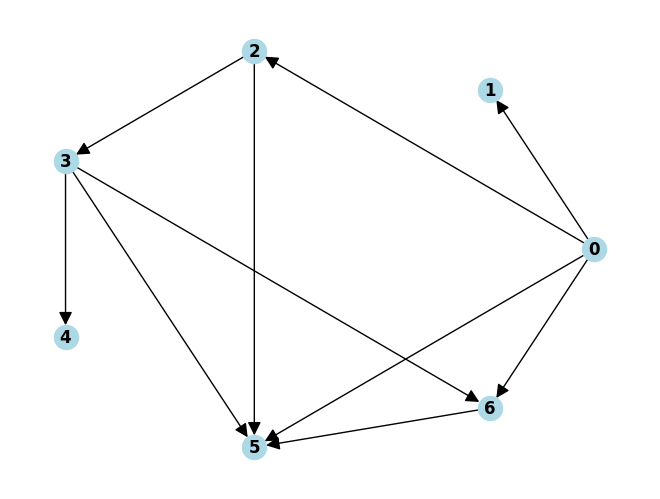

количество компонентов в смеси: 4
средние значения гауссовских распределений: [-0.84468136  0.54675019  0.52817652 -0.66623921]
Ковариации: [0.83165048 0.56180277 0.65401881 0.56116018]
Веса: [0.21473147 0.31974677 0.29149416 0.1740276 ]
7 8 inf
7 1008 inf
7 2008 inf
7 3008 inf
7 4008 inf
7 5008 inf
7 6008 inf
7 7008 inf
7 8008 inf
7 9008 inf
7 10008 inf
7 11008 inf
7 12008 inf
7 13008 inf
7 14008 inf
7 15008 inf
7 16008 inf
7 17008 inf
7 18008 inf
7 19008 inf
7 20008 inf
7 21008 inf
7 22008 inf
7 23008 inf
7 24008 inf
7 25008 inf
7 26008 inf
7 27008 inf
7 28008 inf
7 29008 inf
7 30008 inf
7 31008 inf
7 32008 inf
7 33008 inf
7 34008 inf
7 35008 inf
7 36008 inf
7 37008 inf
7 38008 inf
7 39008 inf
7 40008 inf
7 41008 inf
7 42008 inf
7 43008 inf
7 44008 inf
7 45008 inf
7 46008 inf
7 47008 inf
7 48008 inf
7 49008 inf
7 50008 inf
7 51008 inf
7 52008 inf
7 53008 inf
7 54008 inf
7 55008 inf
7 56008 inf
7 57008 inf
7 58008 inf
7 59008 inf
7 60008 inf
7 61008 inf
7 62008 inf
7 63008 inf
7 64008

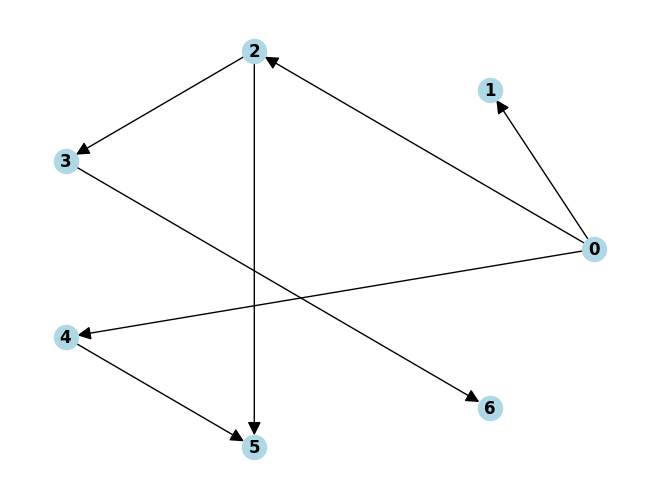

количество компонентов в смеси: 1
средние значения гауссовских распределений: [0.54978258]
Ковариации: [0.62510555]
Веса: [1.]
7 8 inf
7 1008 inf
7 2008 inf
7 3008 inf
7 4008 inf
7 5008 inf
7 6008 inf
7 7008 inf
7 8008 inf
7 9008 inf
7 10008 inf
7 11008 inf
7 12008 inf
7 13008 inf
7 14008 inf
7 15008 inf
7 16008 inf
7 17008 inf
7 18008 inf
7 19008 inf
7 20008 inf
7 21008 inf
7 22008 inf
7 23008 inf
7 24008 inf
7 25008 inf
7 26008 inf
7 27008 inf
7 28008 inf
7 29008 inf
7 30008 inf
7 31008 inf
7 32008 inf
7 33008 inf
7 34008 inf
7 35008 inf
7 36008 inf
7 37008 inf
7 38008 inf
7 39008 inf
7 40008 inf
7 41008 inf
7 42008 inf
7 43008 inf
7 44008 inf
7 45008 inf
7 46008 inf
7 47008 inf
7 48008 inf
7 49008 inf
7 50008 inf
7 51008 inf
7 52008 inf
7 53008 inf
7 54008 inf
7 55008 inf
7 56008 inf
7 57008 inf
7 58008 inf
7 59008 inf
7 60008 inf
7 61008 inf
7 62008 inf
7 63008 22.922
7 64008 21.525
7 65008 22.005
7 66008 22.595
7 67008 21.626
7 68008 20.488
7 69008 19.88
7 70008 19.281
7 71008 17.

In [15]:
p = 0.5
n_nodes = 3
k_samples = 5
folder = 'parameter_learning'
filename_delts = 'delta'
filename_true_structure = 'true_structure'
filename_train_structure = 'train_structure'

for n_nodes in range(4, 8):
    for i in range(5):
        G = np.nan
        G_train = np.nan
        name_exp = str(i)

        G, edges = create_dag(n_nodes, p)
        pos = nx.circular_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold', font_size=12, arrowsize=20)
#         plt.savefig(f'{folder}/{filename_true_structure}_{n_nodes}_{name_exp}_{10**k_samples}.png')
        plt.show()

        df = create_dataset(edges, k_samples)
        df.columns = [f'{i}_' for i in df.columns]

        values = df.values
        columns = df.columns
        sample_disc = desc_data(values, columns)

        model_init = BayesianNetwork(init_edges(edges))
        model_init.fit(
            data=sample_disc,
            estimator=MaximumLikelihoodEstimator
        )

        Score_init = log_likelihood_score(model_init, sample_disc)

        start = len(np.unique(edges))
        end = 10**k_samples + start

        delts = []
        for size in range(start+1, end, 1000):
            delta = train_BN(df, size, edges, Score_init)
            delts.append(delta)
            print(n_nodes, size, delta)
#         (pd.DataFrame(delts)).to_csv(f'{folder}/{n_nodes}_{name_exp}_{10**k_samples}.csv')
        
        

In [16]:
edges

[(0, 1), (0, 2), (0, 4), (2, 3), (2, 5), (3, 6), (4, 5)]